In [99]:
from tarfile import data_filter

import pandas as pd
import numpy as np
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from dask.dataframe import read_csv
from matplotlib.pyplot import xticks
from numpy.ma.core import cumsum
from pandas.core.interchange.dataframe_protocol import DataFrame
from ply.cpp import xrange
from pygments.lexer import bygroups

import volpy_func_lib as vp
import load_clean_lib
import table_lib
import vol_strat_lib as vs

from datetime import datetime
from volpy_func_lib import load_forward_price

In [131]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)

<module 'vol_strat_lib' from 'D:\\Professionelt\\Code\\volpy\\vol_strat_lib.py'>

# Load Data

In [132]:
om_folder = "SPX_full" #SPX_full, i2s1_full_v2
sum_df, od_raw = vs.import_sum_raw(om_folder = om_folder)

In [133]:
price_type = "mid"
IV_type = "om"

od_hl = vs.create_od_hl(od_raw = od_raw, sum_df = sum_df, price_type = price_type, IV_type = IV_type)
sum_df = vs.add_F_to_sum_df(od_hl = od_hl, sum_df = sum_df)

# Find and add ATM options to sum_df

In [134]:
# Define processing configurations
configs = [
    ('low', 'C', 'low_call'),
    ('low', 'P', 'low_put'),
    ('high', 'C', 'high_call'),
    ('high', 'P', 'high_put'),
]

# Process all combinations
pivoted_dfs = [vs.process_options_ATM(od_hl, low_high, cp_flag, prefix) 
              for low_high, cp_flag, prefix in configs]

# Merge all results
for p_df in pivoted_dfs:
    sum_df = sum_df.merge(p_df, on=['ticker', 'date'], how='left')

# Add next price of options to sum_df

In [135]:
# Create next price lookup
od_sorted = od_raw.sort_values(['optionid', 'date']).copy()
od_sorted['price_next'] = od_sorted.groupby('optionid')['price'].shift(-1)
next_price_lookup = od_sorted[['ticker', 'date', 'optionid', 'price_next']]

# Add next prices to all option columns
sum_df = vs.add_next_prices(sum_df, next_price_lookup)

In [136]:
sum_SPX = sum_df[sum_df["ticker"] == "SPX"].reset_index(drop=True)

# Calculate strategy cashflow

In [137]:
# Put and Call (in USD)
for put_call in ["put", "call"]:
    for low_high in ["low", "high"]:
        sum_SPX[f"free_{low_high}_{put_call}"] = (
            sum_SPX[f"{low_high}_{put_call}_1_price_next"] - (1+sum_SPX[f"RF"]) * sum_SPX[f"{low_high}_{put_call}_price_1"]
        ).shift(1)

# Straddle        
for low_high in ["low", "high"]:
    sum_SPX[f"free_{low_high}_straddle"] = sum_SPX[f"free_{low_high}_put"] + sum_SPX[f"free_{low_high}_call"]

In [138]:
# Delta hedged Put and Call (in USD)
for put_call in ["put", "call"]:
    for low_high in ["low", "high"]:
        sum_SPX[f"free_D_{low_high}_{put_call}"] = (
            sum_SPX[f"{low_high}_{put_call}_1_price_next"] - (1+sum_SPX[f"RF"]) * sum_SPX[f"{low_high}_{put_call}_price_1"] - 
            sum_SPX[f"{low_high}_{put_call}_delta_1"] * sum_SPX[f"close"] * (sum_SPX[f"return"].shift(-1) - sum_SPX[f"RF"]) # Delta hedge (self financed)
        ).shift(1)

# Delta hedged Straddle        
for low_high in ["low", "high"]:
    sum_SPX[f"free_D_{low_high}_straddle"] = sum_SPX[f"free_D_{low_high}_put"] + sum_SPX[f"free_D_{low_high}_call"]

In [139]:
# # Put and Call
# for put_call in ["put", "call"]:
#     for low_high in ["low", "high"]:
#         sum_SPX[f"r_{low_high}_{put_call}"] = (
#                 sum_SPX[f"{low_high}_{put_call}_1_price_next"] / sum_SPX[f"{low_high}_{put_call}_price_1"] - 1
#         ).shift(1)

# # Straddle
# for low_high in ["low", "high"]:
#     sum_SPX[f"r_{low_high}_straddle"] = (
#             (sum_SPX[f"{low_high}_call_1_price_next"] + sum_SPX[f"{low_high}_put_1_price_next"]) / 
#             (sum_SPX[f"{low_high}_call_price_1"]      + sum_SPX[f"{low_high}_put_price_1"])-1
#     ).shift(1)

In [144]:
T1 = sum_SPX["low days"].shift(1)
T2 = sum_SPX["high days"].shift(1)

sum_SPX["30_straddle"] = vs.T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX[f"free_low_straddle"], r2 = sum_SPX[f"free_high_straddle"])
sum_SPX["30_D_straddle"] = vs.T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX[f"free_D_low_straddle"], r2 = sum_SPX[f"free_D_high_straddle"])

for put_call in ["put", "call"]:
    sum_SPX[f"30_D_{put_call}"] = vs.T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX[f"free_D_low_{put_call}"], r2 = sum_SPX[f"free_D_high_{put_call}"])
    sum_SPX[f"30_{put_call}"] = vs.T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX[f"free_low_{put_call}"], r2 = sum_SPX[f"free_high_{put_call}"])

In [145]:
sum_SPX["Mkt_change_free"] = sum_SPX[f"close"].diff()-sum_SPX[f"close"].shift(1)*sum_SPX[f"RF"]

# No hedge

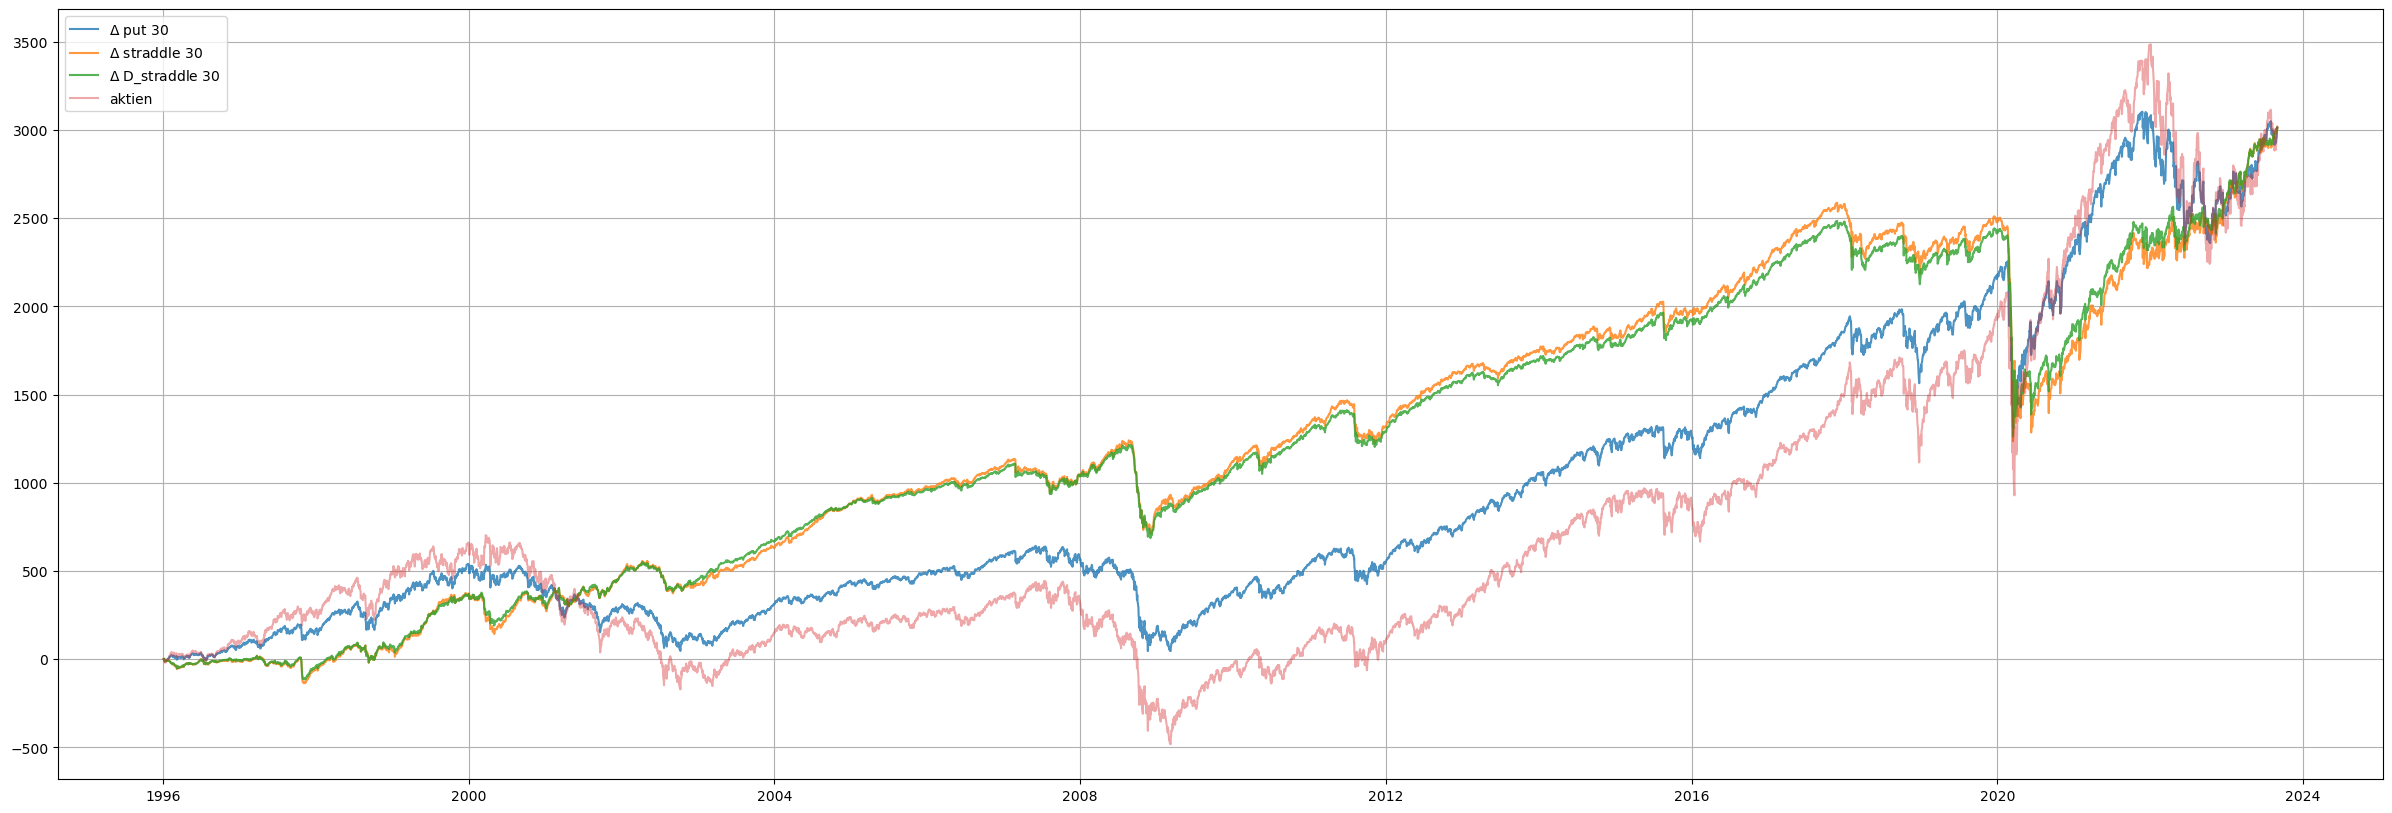

In [146]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX["Mkt_change_free"]).iloc[-1]
    
for put_call in ["put", "straddle", "D_straddle"]:
    last_option_val = np.cumsum(sum_SPX[f"30_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"30_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30", alpha=0.8)

plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["Mkt_change_free"]),
    label="aktien", alpha=0.4)

plt.grid()
plt.legend()
plt.show()

# Plot accumulated cashflow

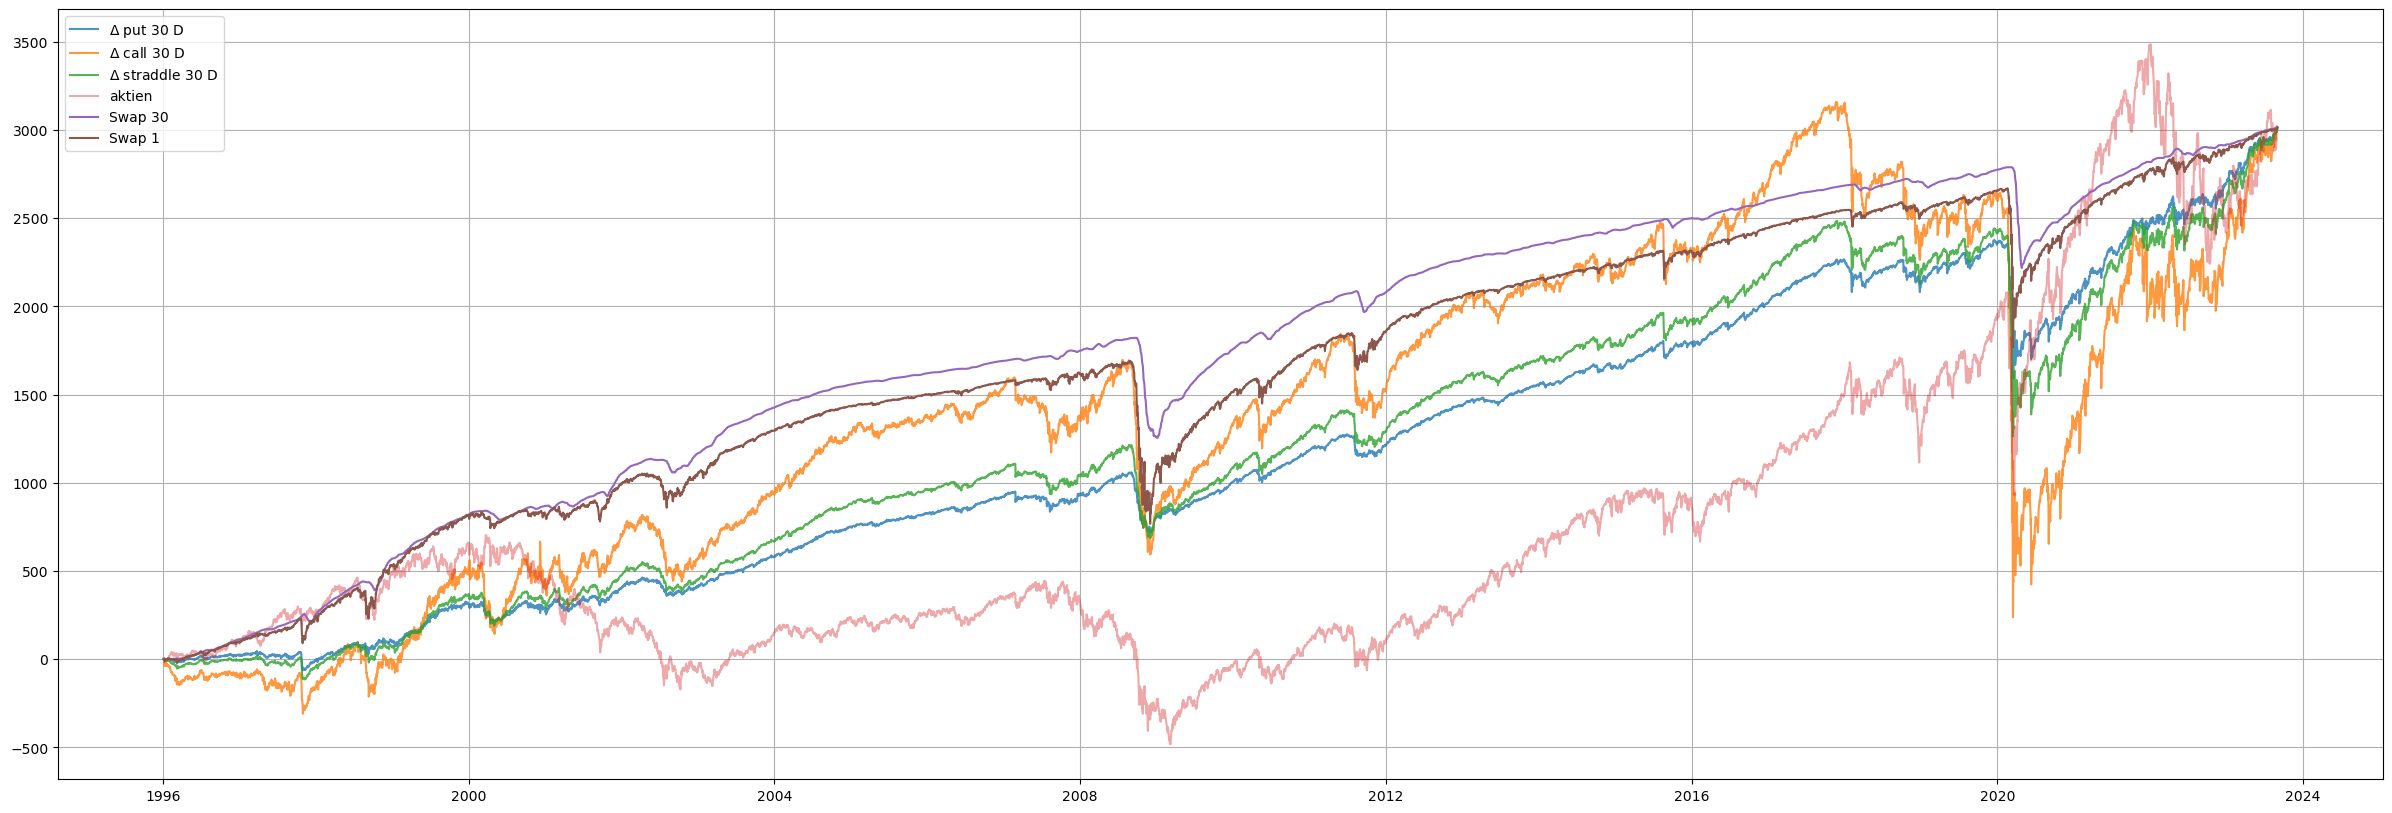

In [185]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX["Mkt_change_free"]).iloc[-1]
    
for put_call in ["put", "call", "straddle"]:
    last_option_val = np.cumsum(sum_SPX[f"30_D_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"30_D_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["Mkt_change_free"]),
    label="aktien", alpha=0.4)

x_SW = sum_SPX["SW_month"]
last_val = np.cumsum(x_SW).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(sum_SPX["date"], scalar * np.cumsum(x_SW), label = "Swap 30")

sum_SPX["SW_day_new"] = sum_SPX["SW_day"]
x_SW_dly = sum_SPX["SW_day_new"]
last_val = np.cumsum(x_SW_dly).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(sum_SPX["date"], scalar * np.cumsum(x_SW_dly), label = "Swap 1")

plt.grid()
plt.legend()
plt.show()

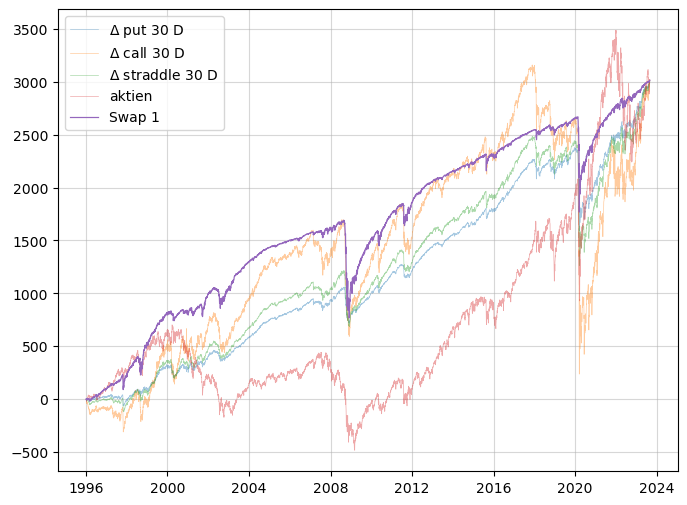

In [208]:
plt.figure(figsize=(8, 6))

lw = 0.5
last_stock_val = np.cumsum(sum_SPX["Mkt_change_free"]).iloc[-1]
    
for put_call in ["put", "call", "straddle"]:
    last_option_val = np.cumsum(sum_SPX[f"30_D_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"30_D_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30 D", alpha=0.4, linewidth=lw)

plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["Mkt_change_free"]),
    label="aktien", alpha=0.4, linewidth=lw)

# x_SW = sum_SPX["SW_month"]
# last_val = np.cumsum(x_SW).iloc[-1]
# scalar = last_stock_val/last_val
# plt.plot(sum_SPX["date"], scalar * np.cumsum(x_SW), label = "Swap 30")

sum_SPX["SW_day_new"] = sum_SPX["SW_day"]
x_SW_dly = sum_SPX["SW_day_new"]
last_val = np.cumsum(x_SW_dly).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(sum_SPX["date"], scalar * np.cumsum(x_SW_dly), label = "Swap 1", linewidth=1.75*lw, alpha=1)

plt.grid(alpha=0.5)
plt.legend()
plt.savefig("figures/acc fig.pdf")
plt.show()

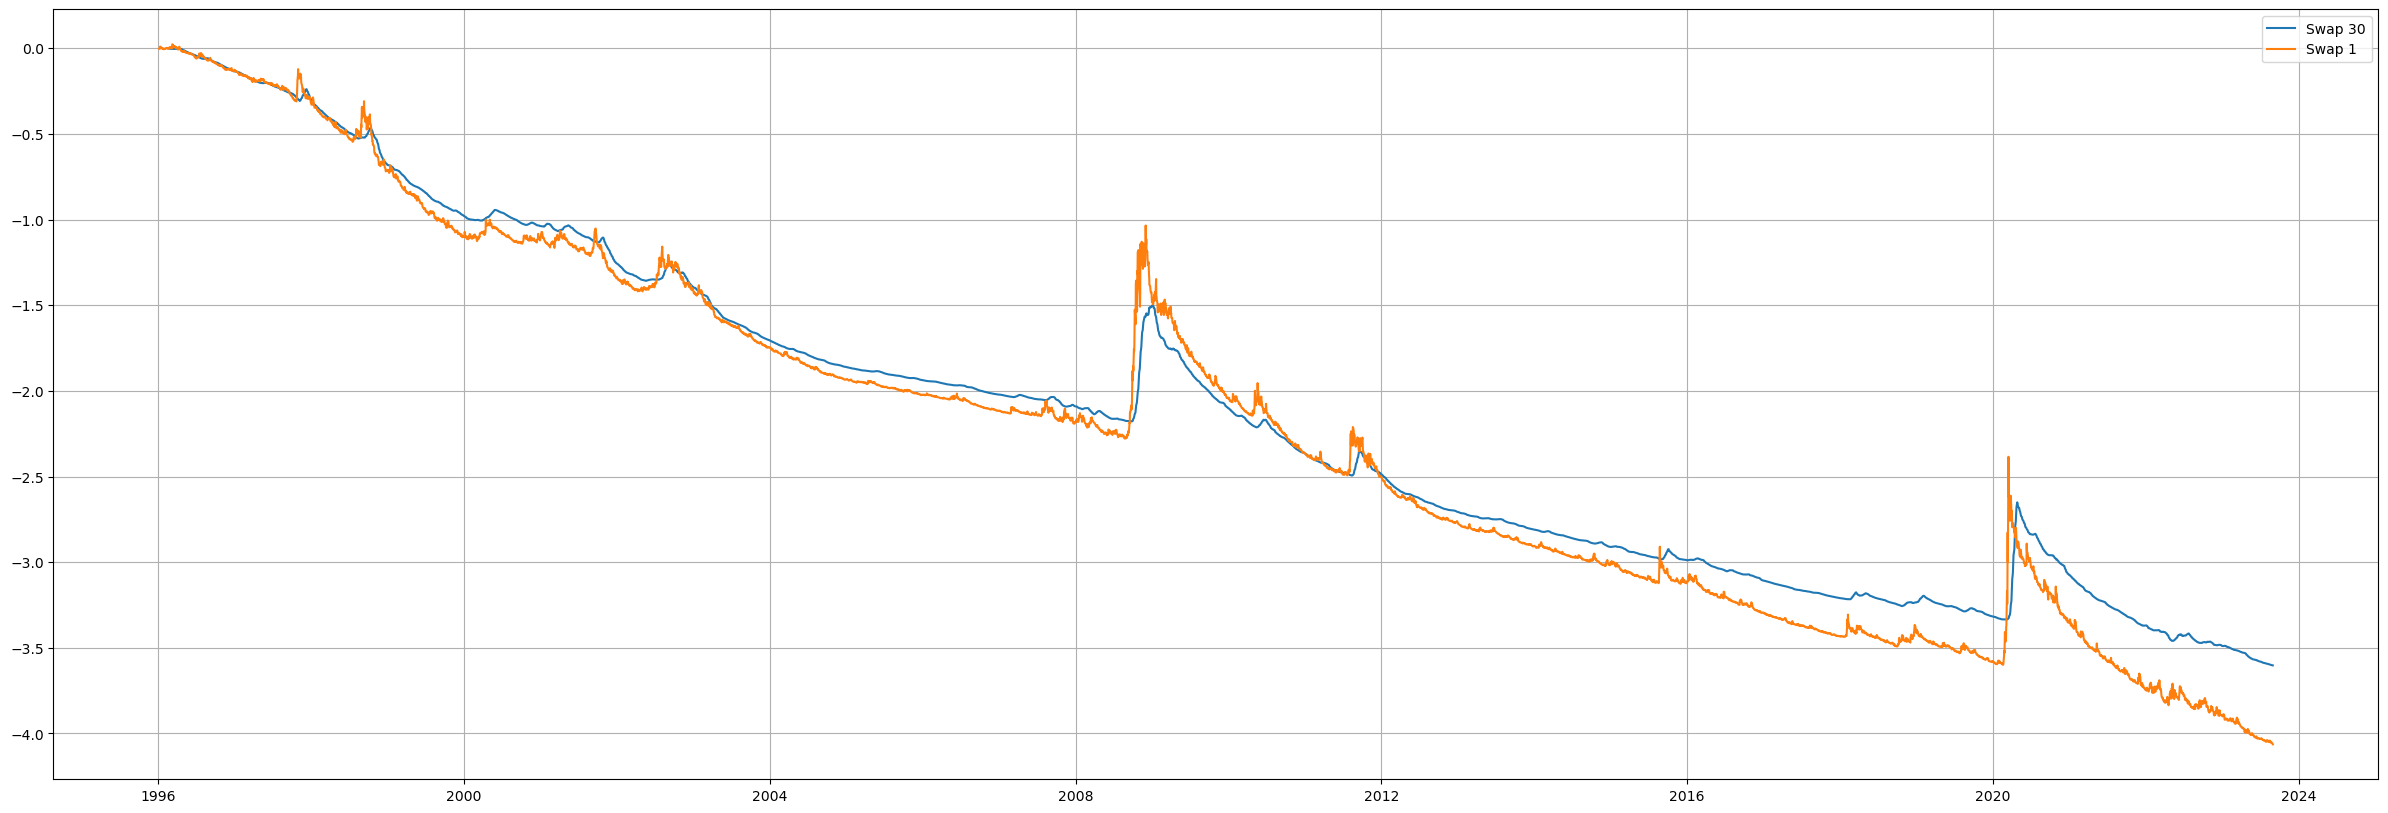

In [188]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX["Mkt_change_free"]).iloc[-1]
    
# for put_call in ["put", "call", "straddle"]:
#     plt.plot(sum_SPX["date"], np.cumsum(sum_SPX[f"30_D_{put_call}"]),
#          label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

# plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["Mkt_change_free"]),
#     label="aktien", alpha=0.4)

x_SW = sum_SPX["SW_month"]
plt.plot(sum_SPX["date"], np.cumsum(x_SW/21), label = "Swap 30")

sum_SPX["SW_day_new"] = sum_SPX["SW_day"]
x_SW_dly = sum_SPX["SW_day_new"]
plt.plot(sum_SPX["date"], np.cumsum(x_SW_dly), label = "Swap 1")

plt.grid()
plt.legend()
plt.show()

In [147]:
sum_SPX["SW_0_29"]

0       0.018725
1       0.016549
2       0.016043
3       0.025788
4       0.025655
          ...   
6961    0.024161
6962    0.022537
6963    0.020623
6964    0.018861
6965    0.017470
Name: SW_0_29, Length: 6966, dtype: float64

In [148]:
sum_SPX["SW_m1_29"]

0            NaN
1       0.018582
2       0.016556
3       0.016039
4       0.025517
          ...   
6961    0.028404
6962    0.024324
6963    0.022703
6964    0.020785
6965    0.019031
Name: SW_m1_29, Length: 6966, dtype: float64

In [156]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)

sum_SPX = vp.interpolate_swaps_and_returns(sum_SPX)
df = sum_SPX

In [157]:
np.mean(df["SW_m1_29"] - 20/21 * df["SW_0_29"])

0.002373468755095014

In [151]:
np.mean(df["SW_m1_29"] - 21/21 * df["SW_0_29"])

7.434367342102508e-05

In [152]:
np.mean(df["SW_m1_29"])

0.04835597038857475

In [153]:
np.mean(df["SW_0_29"])

0.04827738373617639

In [154]:
yr = sum_SPX["date"].dt.year
sum_SPX[yr == 2020]

,ticker,date,index,#days,low days,high days,low #K,high #K,#K,low SW,...,free_D_high_call,free_D_low_straddle,free_D_high_straddle,30_straddle,30_D_straddle,30_D_put,30_put,30_D_call,30_call,Mkt_change_free
6040,SPX,2020-01-02,6040,31.0,30.0,34.0,173.0,272.0,222.5,0.017616,...,0.165162,-1.517915,-1.579449,-1.237313,-1.567142,-1.738364,-14.993707,0.171221,13.756394,26.876153
6041,SPX,2020-01-03,6041,32.0,29.0,33.0,173.0,276.0,224.5,0.021255,...,4.424620,5.425354,5.509187,5.394333,5.425354,1.117285,12.697084,4.308070,-7.302751,-23.195471
6042,SPX,2020-01-06,6042,31.0,28.0,32.0,191.0,279.0,235.0,0.020281,...,-2.646039,-3.506498,-3.257535,-3.093966,-3.444258,-0.648553,-6.090672,-2.795704,2.996707,11.235909
6043,SPX,2020-01-07,6043,31.0,27.0,31.0,188.0,274.0,231.0,0.019932,...,-1.230876,-3.258065,-3.355415,-3.556198,-3.306740,-2.100233,2.421936,-1.206507,-5.978133,-9.294777
6044,SPX,2020-01-08,6044,31.0,30.0,35.0,274.0,193.0,233.5,0.019999,...,0.963900,2.225144,1.849420,2.031317,1.943351,0.951297,-6.840662,0.992054,8.871979,15.675769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6288,SPX,2020-12-24,6288,27.0,28.0,33.0,202.0,138.0,170.0,0.049313,...,-7.675963,-8.561569,-8.546993,-8.190000,-8.558654,-0.895708,-7.240000,-7.662946,-0.950000,13.050000
6289,SPX,2020-12-28,6289,26.0,27.0,32.0,201.0,196.0,198.5,0.050373,...,0.915705,0.169133,0.483322,1.130000,0.294809,-0.526650,-16.260000,0.821459,17.390000,32.300000
6290,SPX,2020-12-29,6290,26.0,26.0,31.0,207.0,202.0,204.5,0.056314,...,3.586668,7.528590,8.804726,8.130000,8.294272,4.982817,9.060000,3.311454,-0.930000,-8.320000
6291,SPX,2020-12-30,6291,26.0,30.0,34.0,201.0,339.0,270.0,0.053341,...,-1.301530,-5.362843,-5.951376,-5.730000,-5.833670,-4.590991,-7.040000,-1.242679,1.310000,5.000000


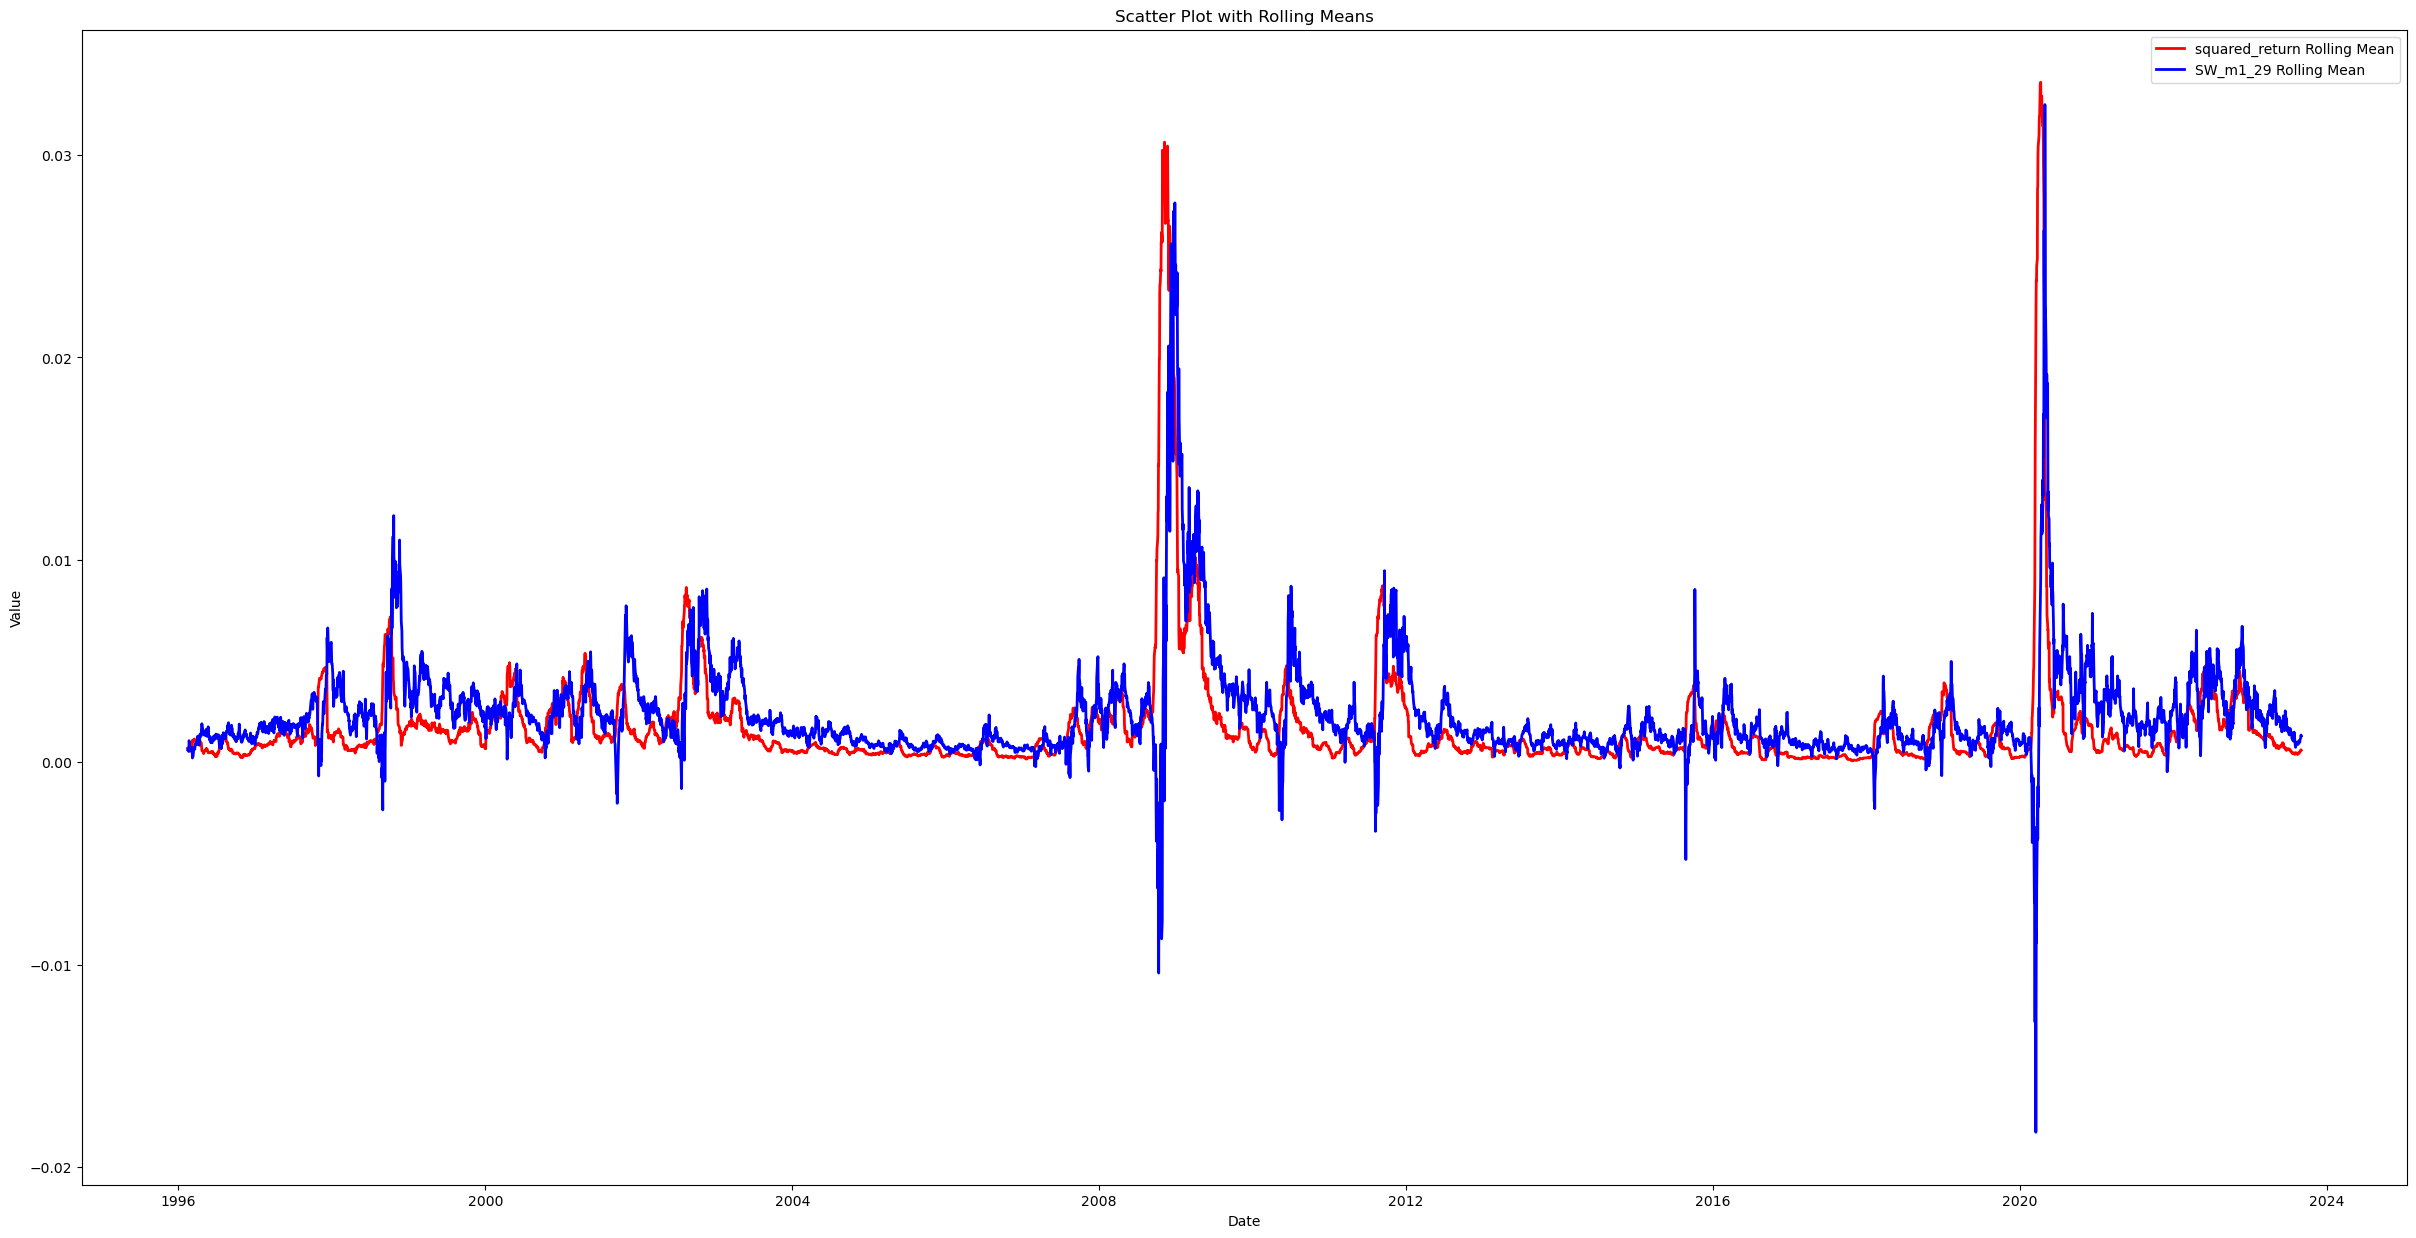

In [184]:
yr = sum_SPX["date"].dt.year
df = sum_SPX#[yr == 2020]

# Define the rolling window size (e.g., 20 days)
window_size = 30

# Compute the rolling mean for each series
df["squared_return_rolling"] = (252/21 * df["squared_return"]).rolling(window=window_size).mean()
df["SW_m1_rolling"] = (df["SW_m1_29"]-df["SW_0_29"]*20/21).rolling(window=window_size).mean()

# Create the plot
plt.figure(figsize=(30,15))

# # Scatter plots of the raw data
# plt.scatter(df["date"], 252 * df["squared_return"], label="squared_return", alpha=0.3)
# plt.scatter(df["date"], df["SW_m1_29"], label="SW_0_29", alpha=0.3)

# Line plots for the rolling means
plt.plot(df["date"], df["squared_return_rolling"], label="squared_return Rolling Mean", color="red", linewidth=2)
plt.plot(df["date"], df["SW_m1_rolling"], label="SW_m1_29 Rolling Mean", color="blue", linewidth=2)

# Adding labels and legend
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Scatter Plot with Rolling Means")
plt.legend()
plt.show()

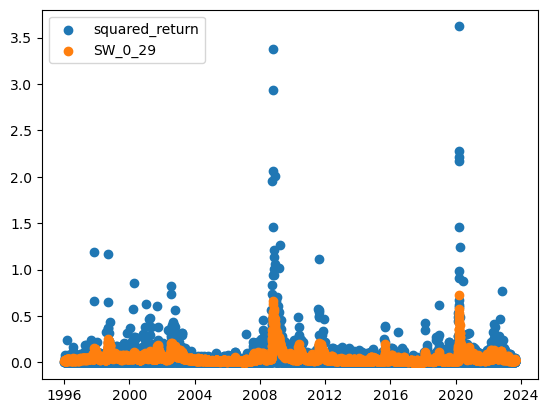

In [159]:
yr = sum_SPX["date"].dt.year
df = sum_SPX#[yr == 2020]
plt.scatter(df["date"], (252 * df["squared_return"]), label = "squared_return")
plt.scatter(df["date"], (df["SW_m1_29"]), label = "SW_0_29")
plt.legend()

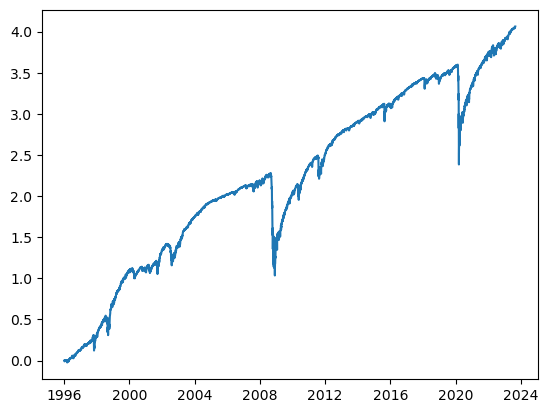

In [177]:
plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["SW_m1_29"]-20/21*sum_SPX["SW_0_29"]-252/21*sum_SPX["squared_return"]), label = "SW_m1_29 - SW_0_29")

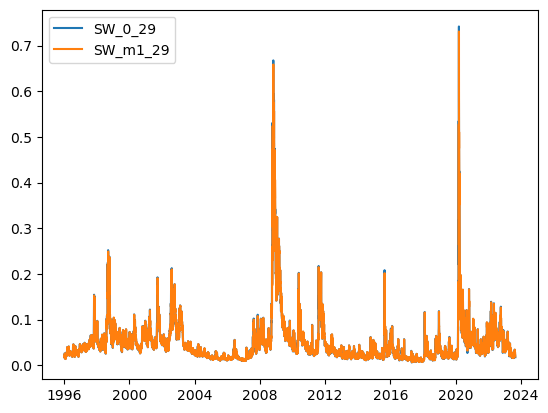

In [167]:
# plt.plot(sum_SPX["date"], 252*sum_SPX["squared_return"], label = "squared_return")
plt.plot(sum_SPX["date"], sum_SPX["SW_0_29"], label = "SW_0_29")
plt.plot(sum_SPX["date"], sum_SPX["SW_m1_29"], label = "SW_m1_29")
plt.legend()
plt.show()

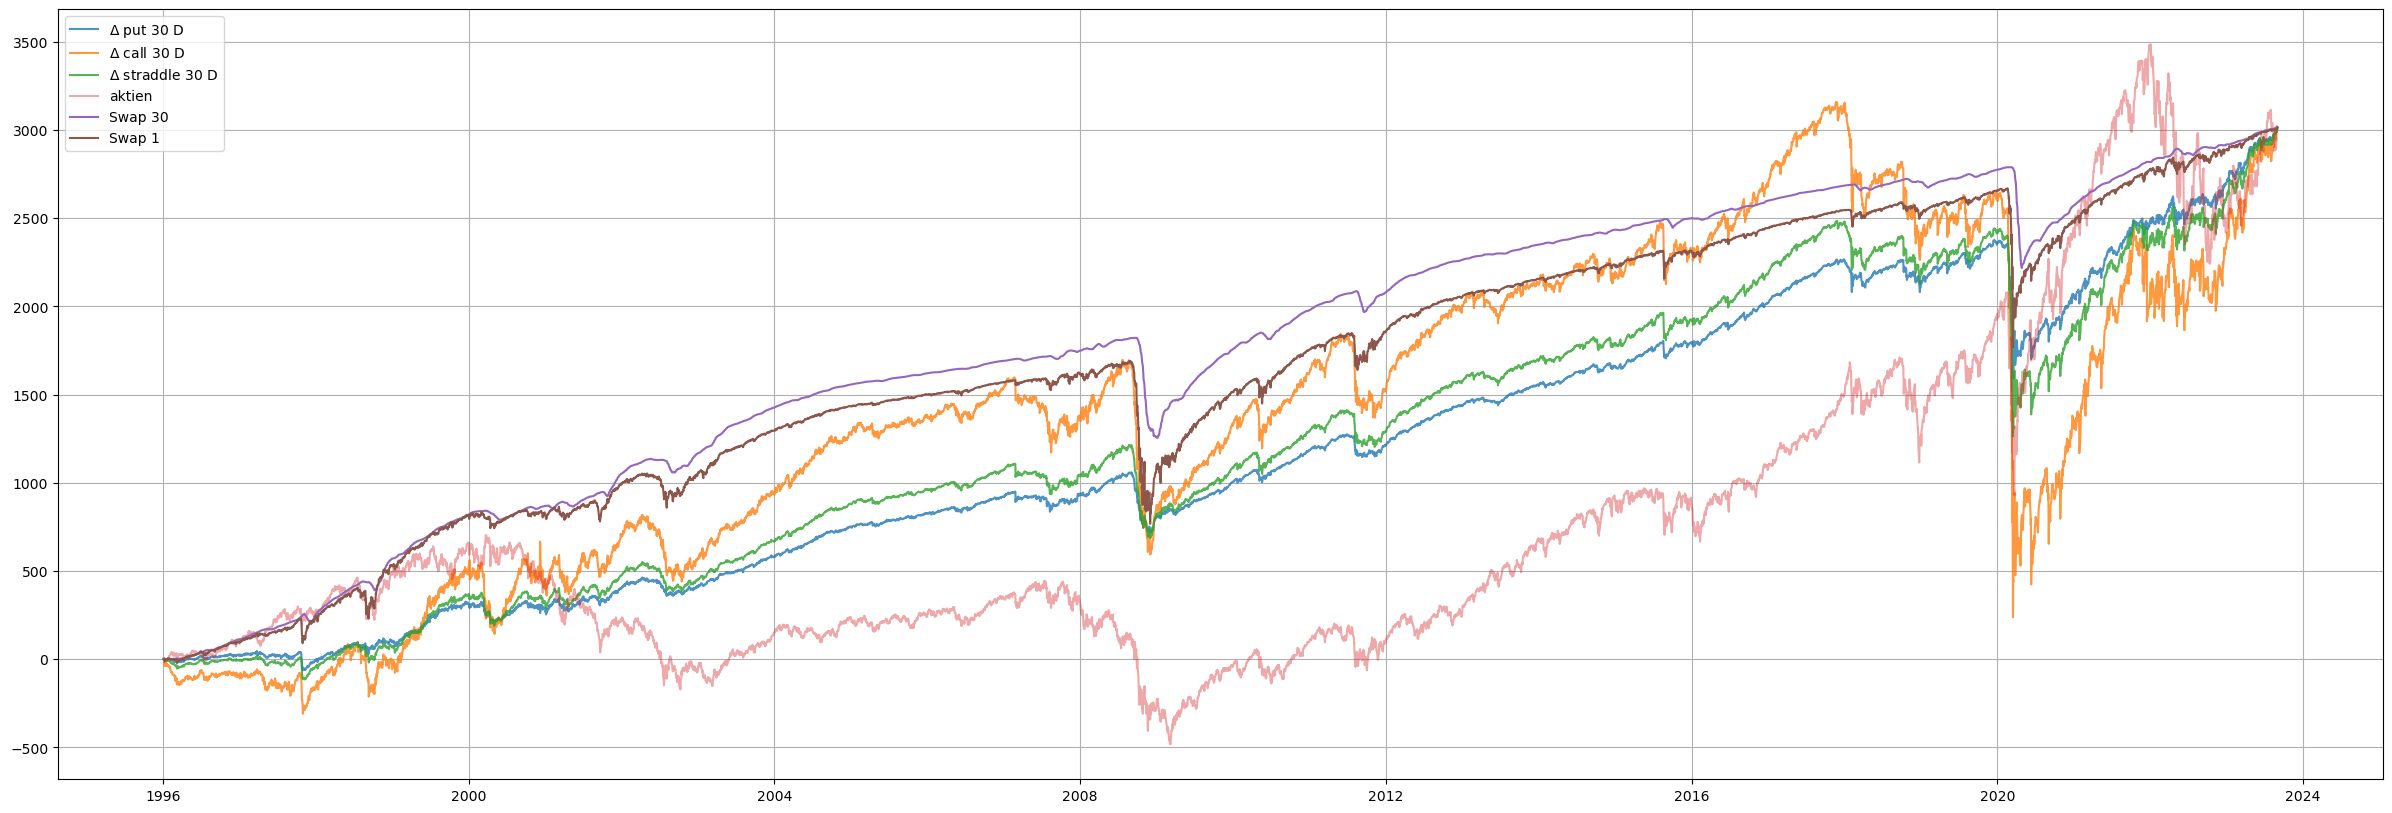

In [164]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX["Mkt_change_free"]).iloc[-1]
    
for put_call in ["put", "call", "straddle"]:
    last_option_val = np.cumsum(sum_SPX[f"30_D_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"30_D_{put_call}"]),
         label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["Mkt_change_free"]),
    label="aktien", alpha=0.4)

x_SW = sum_SPX["SW_month"]
last_val = np.cumsum(x_SW).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(sum_SPX["date"], scalar * np.cumsum(x_SW), label = "Swap 30")

sum_SPX["SW_day_new"] = sum_SPX["SW_day"]
x_SW_dly = sum_SPX["SW_day_new"]
last_val = np.cumsum(x_SW_dly).iloc[-1]
scalar = last_stock_val/last_val
plt.plot(sum_SPX["date"], scalar * np.cumsum(x_SW_dly), label = "Swap 1")

plt.grid()
plt.legend()
plt.show()

# Other figures

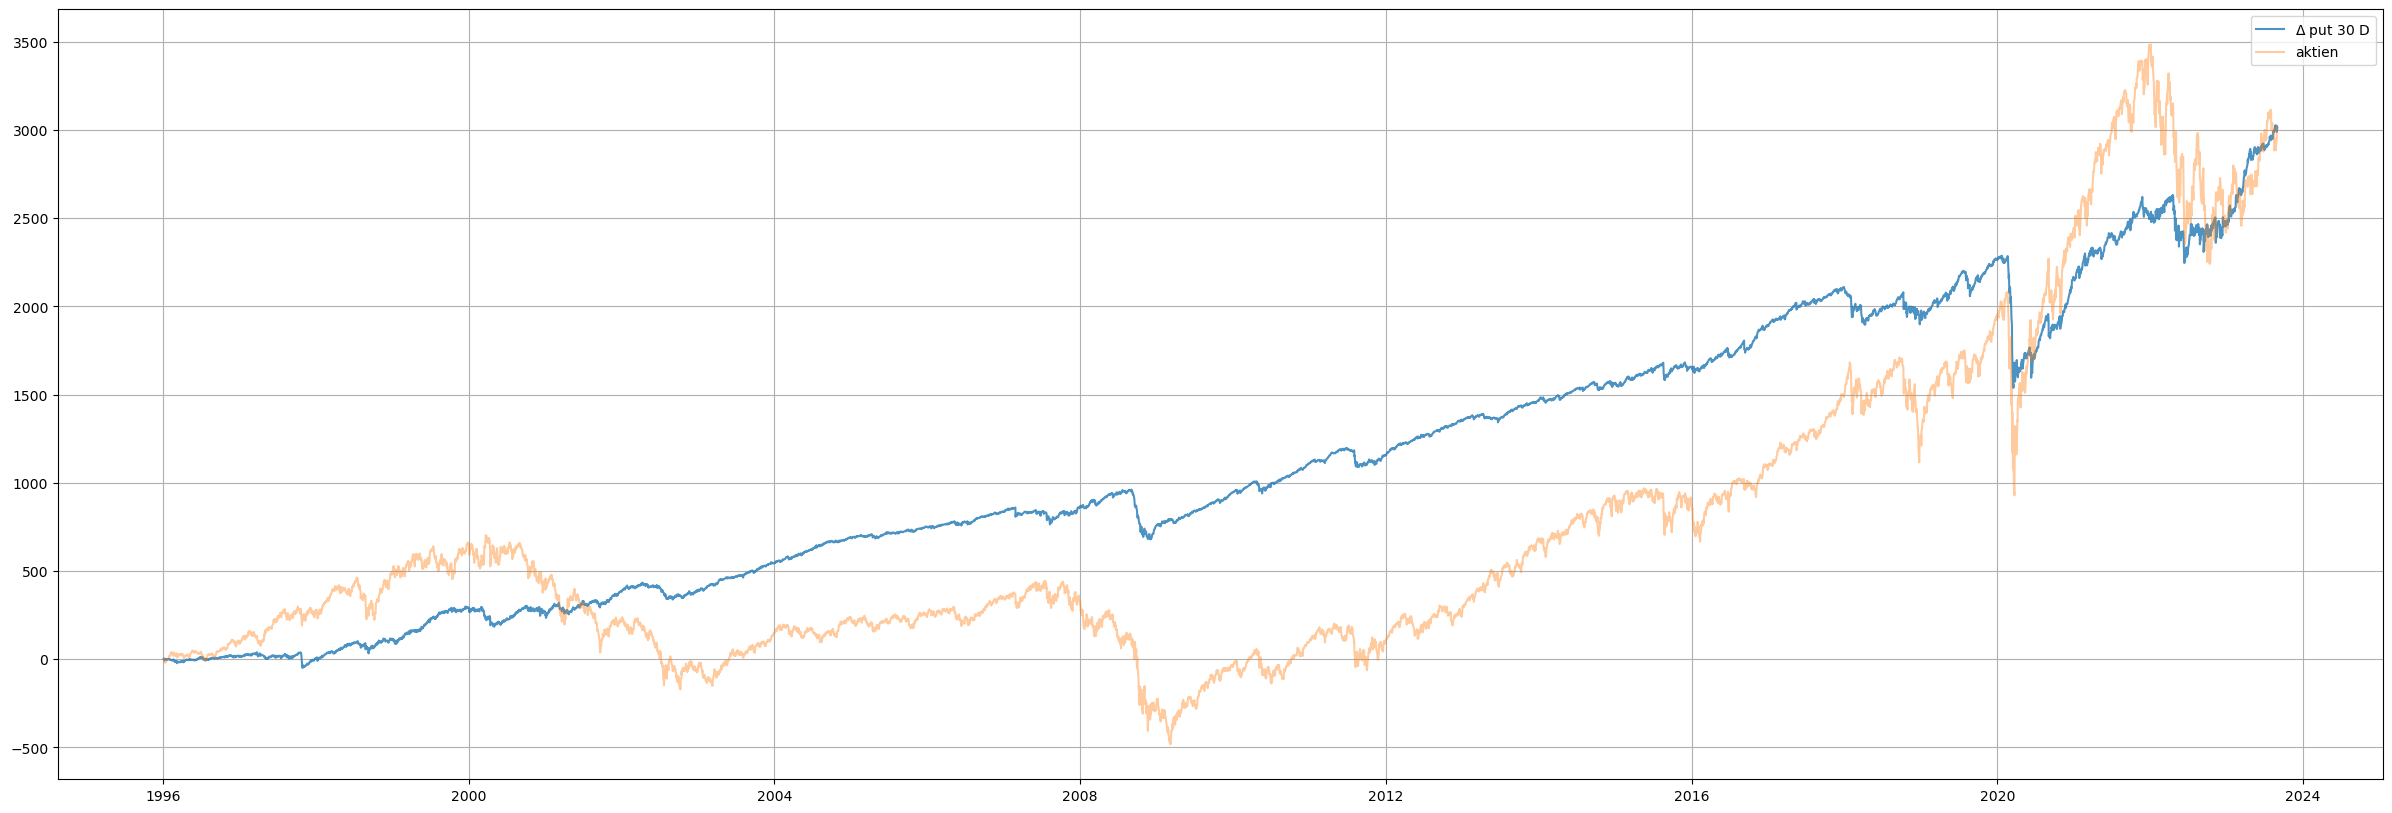

In [78]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX["Mkt_change_free"]).iloc[-1]

put_call = "put"

for low_high in ["low", "high"]:
    last_option_val = np.cumsum(sum_SPX[f"free_D_{low_high}_{put_call}"]).iloc[-1]
    scalar = last_stock_val/last_option_val
    plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"free_D_{low_high}_{put_call}"]),
         label=rf"$\Delta$ {put_call} " + low_high + " D", alpha=0.8)
    
last_option_val = np.cumsum(sum_SPX[f"30_D_{put_call}"]).iloc[-1]
scalar = last_stock_val/last_option_val

plt.plot(sum_SPX["date"], scalar * np.cumsum(sum_SPX[f"30_D_{put_call}"]),
     label=rf"$\Delta$ {put_call} 30 D", alpha=0.8)

plt.plot(sum_SPX["date"], np.cumsum(sum_SPX["Mkt_change_free"]),
    label="aktien", alpha=0.4)

plt.grid()
plt.legend()
plt.show()